# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.mps.is_available()

if not train_on_gpu:
    print('MPS is not available.  Training on CPU ...')
else:
    print('MPS is available!  Training on MPS ...')

MPS is available!  Training on MPS ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [23]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("mps")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = torch.tensor(label_id.item(), dtype=torch.long)
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./journey-springfield/train/')
TEST_DIR = Path('./journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [9]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

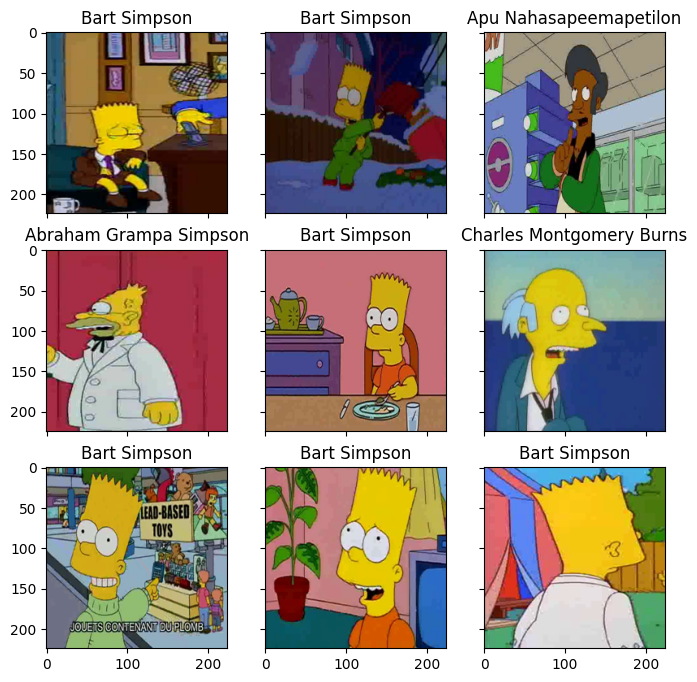

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [34]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        running_corrects += preds.eq(labels).sum().item()
        preds.eq(labels).sum().item()
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# def predict(model, test_loader):
#     with torch.no_grad():
#         logits = []

#         for inputs in test_loader:
            
#             if inputs.ndim == 4 and inputs.shape[-1] == 3:  # Проверяем формат [B, H, W, C]
#                 inputs = inputs.permute(0, 3, 1, 2)  # Меняем на [B, C, H, W]
#             if inputs.dtype != torch.float32:  # Проверяем тип данных
#                 inputs = inputs.float()  # Преобразуем в float32, если нужно
#             inputs = inputs.to(DEVICE)
#             model.eval()
#             outputs = model(inputs).cpu()
#             logits.append(outputs)

#     probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
#     return probs

In [15]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [16]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [42]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|                                                                                                                                      | 0/2 [00:00<?, ?it/s]

loss 2.6514721791663285


epoch:  50%|███████████████████████████████████████████████████████████████                                                               | 1/2 [01:27<01:27, 87.39s/it]


Epoch 001 train_loss: 2.6515     val_loss 1.9789 train_acc 0.2589 val_acc 0.4549
loss 1.575479208621958


epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:44<00:00, 82.44s/it]


Epoch 002 train_loss: 1.5755     val_loss 1.3920 train_acc 0.5677 val_acc 0.6215


Построим кривые обучения

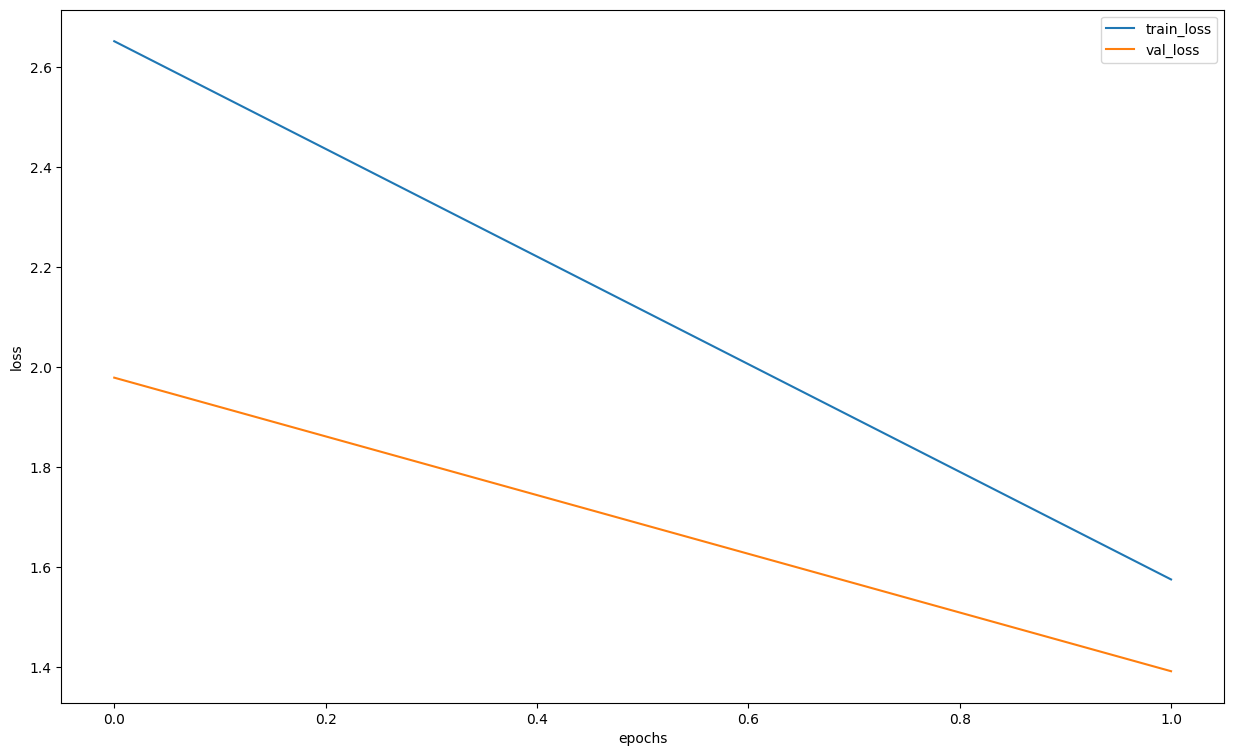

In [43]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [44]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [45]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [46]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [47]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [48]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [49]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.4


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

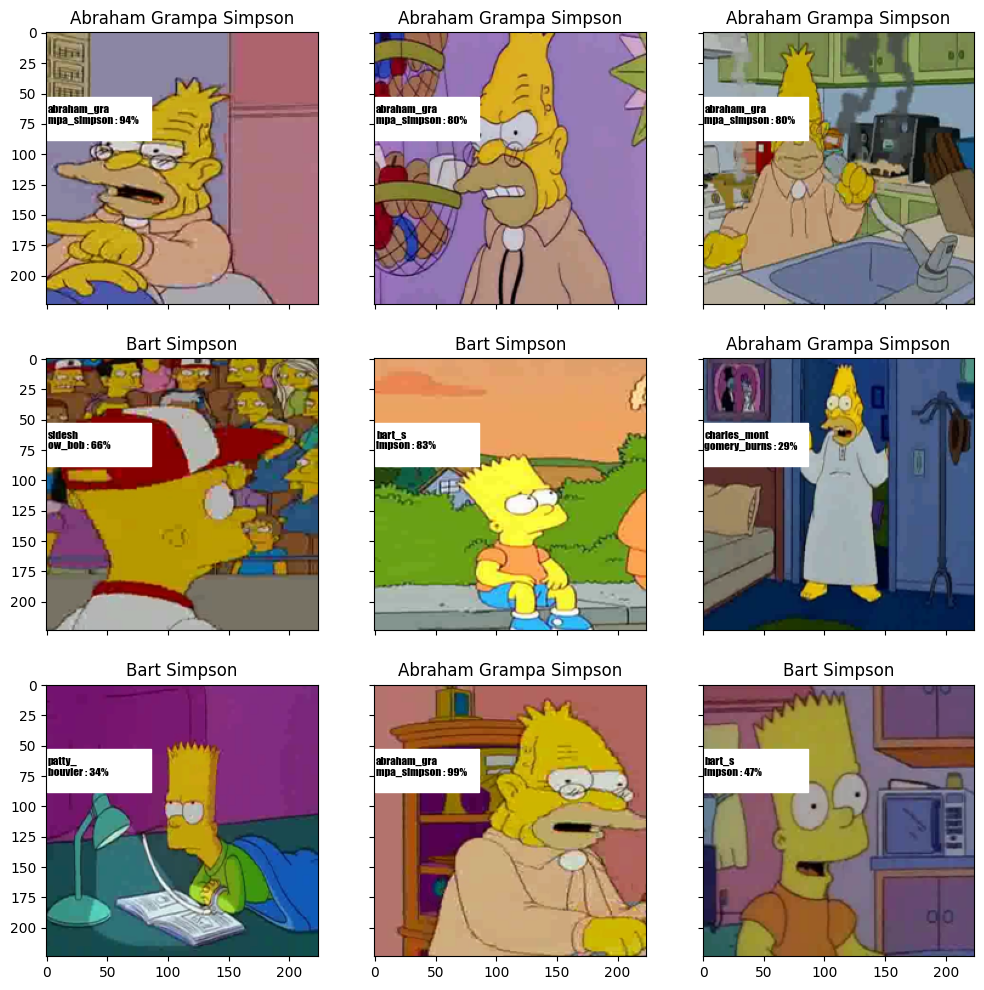

In [50]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [51]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [52]:
len(preds)

991

In [53]:
! ls

efficient_net.csv            simple_cnn_baseline.csv
efficient_net_pretrained.csv simple_cnn_step_1.csv
journey-springfield          simple_cnn_step_2.csv
journey-springfield.zip      simple_cnn_step_3.csv
label_encoder.pkl            simpsons_baseline.ipynb


In [54]:
import pandas as pd
# my_submit = pd.read_csv("./journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [55]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [56]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Планы на эксперименты
После каждого эксперимента будем делать сабмит на каггл и смотреть итоговый скор.

1. Увеличим кол-во эпох до 10ти

# Шаг 1 - Работа с данными

Увеличиваем кол-во эпох до 10ти.

In [60]:
import os

statistics = {}
class_nums_stats = []
path_to_train = r"journey-springfield/train/simpsons_dataset"
for dir_name in os.listdir(path_to_train):
    path_to_class_folder = Path(os.path.join(path_to_train, dir_name))
    imgs_nums = len(list(path_to_class_folder.rglob('*.jpg')))
    statistics[dir_name] = imgs_nums
    if imgs_nums != 0:
        class_nums_stats.append(imgs_nums)


In [61]:
print(f"Медианное кол-во файлов в классе: {np.median(class_nums_stats)}")
print(f"Максимальное кол-во файлов в классе: {np.max(class_nums_stats)}")
print(f"Минимальное кол-во файлов в классе: {np.min(class_nums_stats)}")

Медианное кол-во файлов в классе: 154.5
Максимальное кол-во файлов в классе: 2246
Минимальное кол-во файлов в классе: 3


In [ ]:
# Сделаем простейший алгоритм, дополним кол-во картинок в классе до максимальной простейшей операцией случайного копровани
import random
import shutil
max_images = np.max(class_nums_stats)

# пройдемся повторно по всем репозиториям и просто сделаем копии изображений для класса такого колва, что бы их число равнялось
# max_images
for dir_name in os.listdir(path_to_train):
    path_to_class_folder = Path(os.path.join(path_to_train, dir_name))
    imgs_nums = list(path_to_class_folder.rglob('*.jpg'))
    if  0 < len(imgs_nums) < max_images:        
        print(f"class name: {dir_name} nums: {max_images-len(imgs_nums)}")
        for idx in range(max_images-len(imgs_nums)):
            img_to_copy = random.choice(imgs_nums)
            new_file_name = f"{img_to_copy.stem}_{idx}{img_to_copy.suffix}"
            shutil.copy(img_to_copy, str(img_to_copy.parent)+"/"+new_file_name)


In [ ]:
import os

statistics = {}
class_nums_stats = []
path_to_train = r"journey-springfield/train/simpsons_dataset"
for dir_name in os.listdir(path_to_train):
    path_to_class_folder = Path(os.path.join(path_to_train, dir_name))
    imgs_nums = len(list(path_to_class_folder.rglob('*.jpg')))
    statistics[dir_name] = imgs_nums
    if imgs_nums != 0:
        class_nums_stats.append(imgs_nums)
print(statistics)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./journey-springfield/train/')
TEST_DIR = Path('./journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

# Шаг 1

Просто увеличиваем кол-во эпох на обучение с двух до 10.

In [57]:
epoch_nums = 10

In [58]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [59]:
# Создаем объект нейронной сети
simple_cnn_step_1 = SimpleCnn(n_classes).to(DEVICE)

history = train(train_dataset, val_dataset, model=simple_cnn_step_1, epochs=epoch_nums, batch_size=64)

epoch:   0%|                                                                                                                                     | 0/10 [00:00<?, ?it/s]

loss 2.498385569230562


epoch:  10%|████████████▌                                                                                                                | 1/10 [01:22<12:19, 82.14s/it]


Epoch 001 train_loss: 2.4984     val_loss 1.9306 train_acc 0.3062 val_acc 0.4807
loss 1.5666854334178264


epoch:  20%|█████████████████████████                                                                                                    | 2/10 [02:45<11:02, 82.81s/it]


Epoch 002 train_loss: 1.5667     val_loss 1.4438 train_acc 0.5698 val_acc 0.6099
loss 1.0838545309418257


epoch:  30%|█████████████████████████████████████▌                                                                                       | 3/10 [04:02<09:22, 80.37s/it]


Epoch 003 train_loss: 1.0839     val_loss 1.1586 train_acc 0.6990 val_acc 0.6932
loss 0.7790835384931812


epoch:  40%|██████████████████████████████████████████████████                                                                           | 4/10 [05:21<07:57, 79.51s/it]


Epoch 004 train_loss: 0.7791     val_loss 1.0299 train_acc 0.7806 val_acc 0.7400
loss 0.5567468781992617


epoch:  50%|██████████████████████████████████████████████████████████████▌                                                              | 5/10 [06:41<06:38, 79.67s/it]


Epoch 005 train_loss: 0.5567     val_loss 1.0301 train_acc 0.8414 val_acc 0.7488
loss 0.41673512732620427


epoch:  60%|███████████████████████████████████████████████████████████████████████████                                                  | 6/10 [08:00<05:18, 79.60s/it]


Epoch 006 train_loss: 0.4167     val_loss 0.9957 train_acc 0.8800 val_acc 0.7738
loss 0.31066544631596804


epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 7/10 [09:17<03:56, 78.88s/it]


Epoch 007 train_loss: 0.3107     val_loss 1.0348 train_acc 0.9080 val_acc 0.7820
loss 0.23491349652399113


epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8/10 [10:36<02:37, 78.71s/it]


Epoch 008 train_loss: 0.2349     val_loss 1.1157 train_acc 0.9273 val_acc 0.7774
loss 0.17689284837844305


epoch:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9/10 [11:55<01:18, 78.87s/it]


Epoch 009 train_loss: 0.1769     val_loss 1.3194 train_acc 0.9437 val_acc 0.7690
loss 0.1454425596611478


epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:10<00:00, 79.03s/it]


Epoch 010 train_loss: 0.1454     val_loss 1.3450 train_acc 0.9524 val_acc 0.7906


In [62]:
loss, acc, val_loss, val_acc = zip(*history)

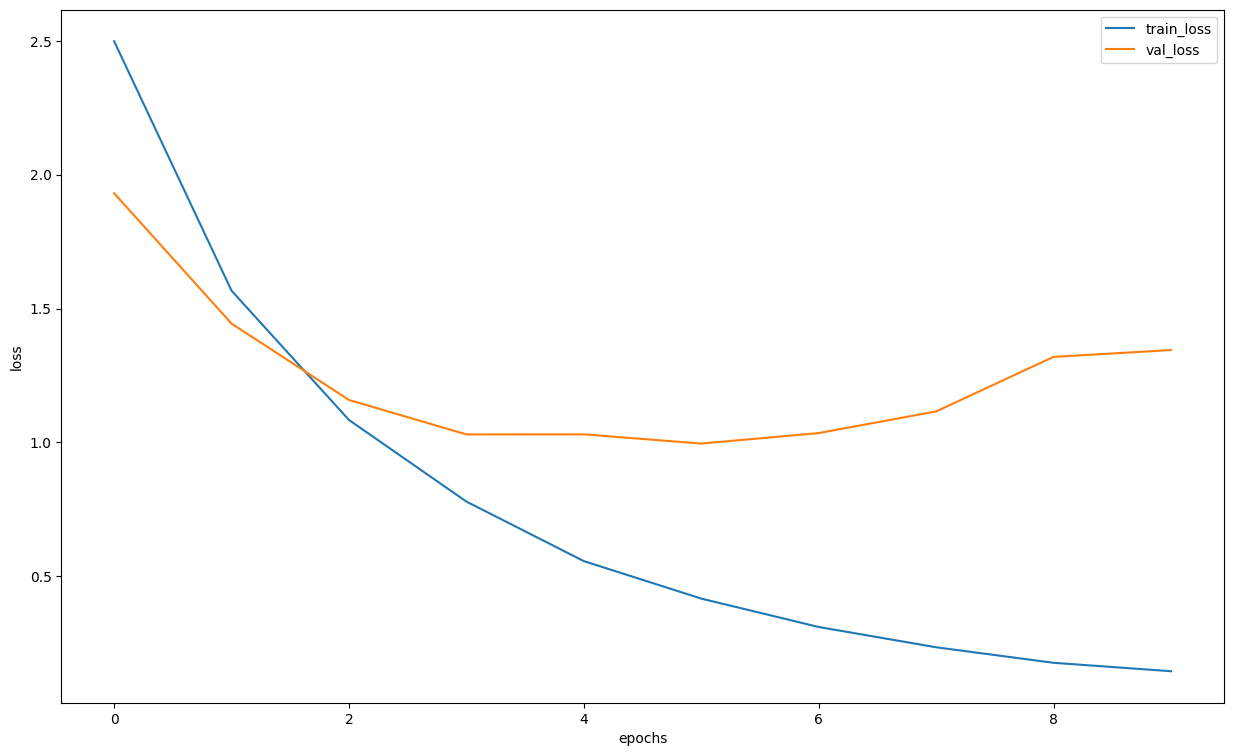

In [63]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [73]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn_step_1, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1 = f1_score(actual_labels, y_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.95


In [65]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn_step_1, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('simple_cnn_step_1.csv', index=False)

# Вывод по шагу 1

Простое увеличение числа шагов, дает лучшее качество, однако важно заметить, что примерно с 3ей эпохи лосс на валидации немного начинает расти, тогда как на трейне снижается, это может говорить нам о переобучении. Поэтому необходимо подумать в сторону улучшения самой сетки.

Ключевые метрики:  
**Kaggle**: 0.91710

# Шаг 2

В данном шаге мы попробуем различные архитектурные трюки с нейронной сетью, а именно:  
1. Добавим слой дропаута, так как он хорошо помогает бороться с переобучением сети.
2. Поменяем функцию активации с Relu, на Leaky Relu.
3. Добавим еще один полносвязанный слой после сверточных слоев (пример сети AlexNet).

Этот эксперимент не совсем корректен, так как тут мы меняем сразу несколько параметров, но мы все же попробуем сразу такую комбинацию.
Также мы не будем добавлять слой BatchNorm, так как у нас сеть неглубокая и вместо этого слоя мы добавим слой DropOut.

In [69]:
# Базовая сетка с добавленным батчнормом
class Step2nn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 1200),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1200, 600),  # Второй полносвязанный слой
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.5)
        )

        self.out = nn.Linear(600, n_classes)  # Финальный выходной слой



    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        logits = self.out(x)
        return logits

In [70]:
# Создаем объект нейронной сети
simple_cnn_step_2 = Step2nn(n_classes).to(DEVICE)

history = train(train_dataset, val_dataset, model=simple_cnn_step_2, epochs=10, batch_size=64)

epoch:   0%|                                                                                                                                     | 0/10 [00:00<?, ?it/s]

loss 2.7896693559412484


epoch:  10%|████████████▌                                                                                                                | 1/10 [01:25<12:45, 85.04s/it]


Epoch 001 train_loss: 2.7897     val_loss 2.1823 train_acc 0.2115 val_acc 0.4337
loss 1.5289166937421723


epoch:  20%|█████████████████████████                                                                                                    | 2/10 [02:45<10:56, 82.08s/it]


Epoch 002 train_loss: 1.5289     val_loss 1.2066 train_acc 0.5800 val_acc 0.6660
loss 0.9084686200568172


epoch:  30%|█████████████████████████████████████▌                                                                                       | 3/10 [04:01<09:16, 79.43s/it]


Epoch 003 train_loss: 0.9085     val_loss 0.9363 train_acc 0.7400 val_acc 0.7396
loss 0.5469365790965671


epoch:  40%|██████████████████████████████████████████████████                                                                           | 4/10 [05:14<07:42, 77.00s/it]


Epoch 004 train_loss: 0.5469     val_loss 0.8722 train_acc 0.8409 val_acc 0.7717
loss 0.31763433453132944


epoch:  50%|██████████████████████████████████████████████████████████████▌                                                              | 5/10 [06:27<06:18, 75.60s/it]


Epoch 005 train_loss: 0.3176     val_loss 0.8726 train_acc 0.9041 val_acc 0.8055
loss 0.20967004682385348


epoch:  60%|███████████████████████████████████████████████████████████████████████████                                                  | 6/10 [07:39<04:57, 74.43s/it]


Epoch 006 train_loss: 0.2097     val_loss 1.0957 train_acc 0.9343 val_acc 0.7801
loss 0.14049551455707784


epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 7/10 [08:51<03:40, 73.57s/it]


Epoch 007 train_loss: 0.1405     val_loss 1.0304 train_acc 0.9567 val_acc 0.8065
loss 0.11874866280549308


epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8/10 [10:04<02:26, 73.35s/it]


Epoch 008 train_loss: 0.1187     val_loss 1.1329 train_acc 0.9622 val_acc 0.7984
loss 0.08681640868217629


epoch:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9/10 [11:16<01:12, 72.87s/it]


Epoch 009 train_loss: 0.0868     val_loss 1.1545 train_acc 0.9727 val_acc 0.8109
loss 0.08451489043823131


epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:27<00:00, 74.80s/it]


Epoch 010 train_loss: 0.0845     val_loss 1.3657 train_acc 0.9747 val_acc 0.7963


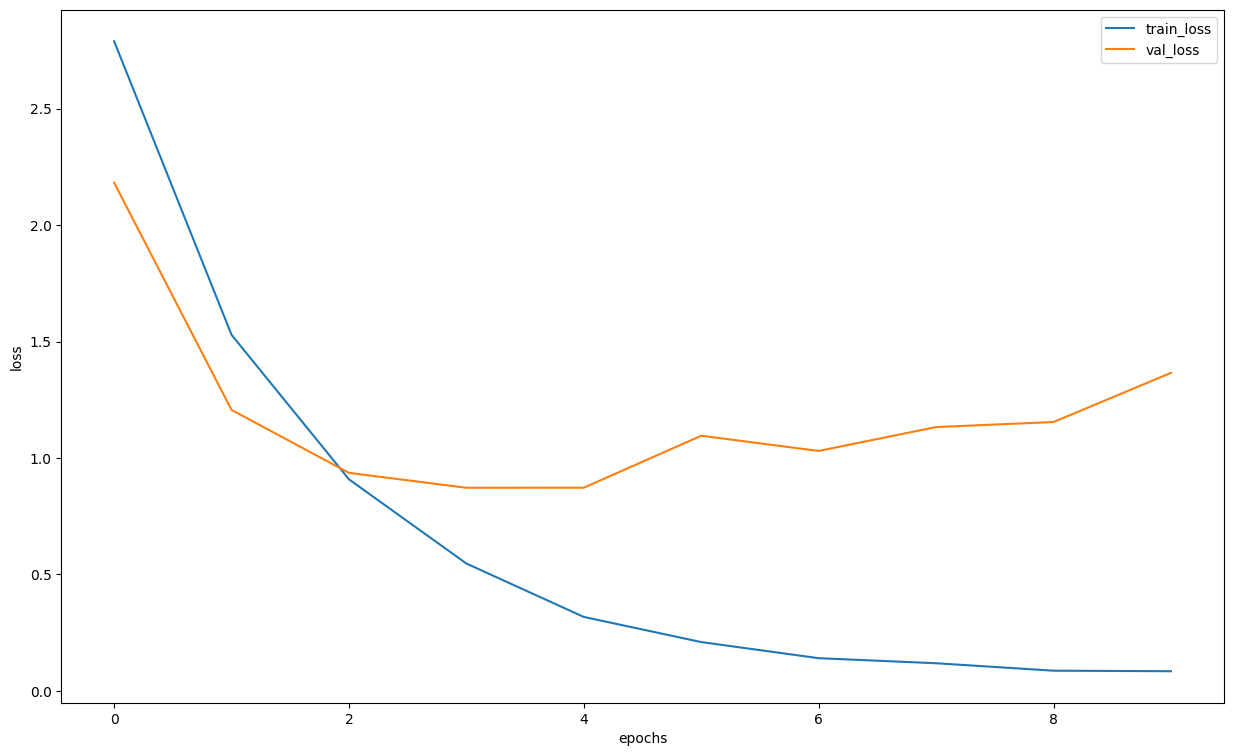

In [71]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [75]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn_step_2, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('simple_cnn_step_2.csv', index=False)

# Вывод по шагу 2:

На графиках изменения лосс функции по прежнему наблюдается такая проблема как рост значения лосс функции после некоторой эпохи. Данную проблему скорее всего можно попробовать победить с помощью добавления аугментации в данных. Небольшое изменение архитектуры сети позволило повысить метрику на Kaggle.

Ключевые метрики:  
**Kaggle**: 0.93304

# Шаг 3

Для данного шага мы сделаем изменения в функции обучения модели:  
1. Будем использовать оптимизатор AdamW с параметрами lr=1e-3, weight_decay=1e-4.
2. Добавим шедулер для изменения lr.  
3. Добавим возможность сохранения лучшей модели в файл, что бы потом загружать именно лучшую версию модели.
4. Добавим функционал ранней остановки обучения если у нас не улучшается метрика на валидации.
5. Увеличим число эпох обучения до 30.  

Архитектуру сети мы не меням.

In [18]:
from torch.utils.tensorboard import SummaryWriter

def train(train_files, val_files, model, epochs, batch_size, save_path="best_model.pth", log_dir="./logs"):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    writer = SummaryWriter(log_dir)
    best_val_acc = 0.0
    no_improvement_epochs = 0
    early_stopping_patience = 10

    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', patience=5, factor=0.1, verbose=True)

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)

        # TensorBoard logging
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Validation", val_acc, epoch)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        scheduler.step(val_acc)

        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

    writer.close()
    return best_val_acc

In [80]:
# Создаем объект нейронной сети
simple_cnn_step_3 = Step2nn(n_classes).to(DEVICE)

history = train(train_dataset, val_dataset, model=simple_cnn_step_3, epochs=30, batch_size=64)

/Users/antoneremin/Documents/JupyterLab/python_dir/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [83]:
# загрузим лучшую модель
step_3_best_model = Step2nn(n_classes=n_classes)

# Загрузка сохранённой модели
save_path = "best_model.pth"
step_3_best_model.load_state_dict(torch.load(save_path))
step_3_best_model.to(DEVICE)

# Перевод модели в режим оценки
step_3_best_model.eval()

/var/folders/41/n7_9wnf56qx297ptlc9z23dc0000gn/T/ipykernel_9904/2787127062.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  step_3_best_model.load_state_dict(torch.load(s

Step2nn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  

In [84]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(step_3_best_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('improved_cnn_step_3.csv', index=False)

# Вывод по шагу 3:

Изменение оптимизатора, а также добавления шедулера. Плюс возможность сохраенения и использования только самой лучшей сети, довольно существенно повысило качество.

Ключевые метрики:  
**Kaggle**: 0.95855

# Шаг 4

На данном шаге мы выберем какую-то SOTA сеть и обучим её на наших данных. Как правило сети обученные на большом объеме данных, а 
затем доученные на наших данных, показывают существенно более лучшие результаты, нежели обученная сеть с 0.

В качестве базовой модели будем использовать efficientnet_v2_s

In [108]:
def initialize_model_resnet(n_classes):
    model = models.resnet50(pretrained=True, weights="IMAGENET1K_V2")
    for param in model.parameters():
        param.requires_grad = False  # Заморозка весов
    model.fc = nn.Linear(model.fc.in_features, n_classes, bias=True)  # Заменяем последний слой
    return model

In [19]:
from torchvision.models import resnet50


model = resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, n_classes, bias=True)  # Заменяем последний слой
model.to(DEVICE)

history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=128)

/Users/antoneremin/Documents/JupyterLab/python_dir/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Загрузка сохранённой модели
save_path = "best_model.pth"
model.load_state_dict(torch.load(save_path))
model.to(DEVICE)

# Перевод модели в режим оценки
model.eval()

/var/folders/41/n7_9wnf56qx297ptlc9z23dc0000gn/T/ipykernel_48911/2572430473.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet_50.csv', index=False)

# Вывод по шагу 4

Использование техники Transfer Learning довольно существенно улучшило качество модели.

Ключевые метрики:
**Kaggle**: 0.99468

# Вывод

Были испровбованые различные техники улучшения модели, начиная от банального увеличиения числа эпох и заканчивая модификацией архитектуры сети, использованием более сложных оптимизаторов и шедулеров, а также использвалась техника transfer learning. Лучшее значение ключевой метрики было равно 0.99468.

Не использовались техники аугментации данных + в этой задаче можно было поискать в открытых источниках изображений героев, с малым количеством данных.

**Ник на Kaggle:** Anton_Eryomin_2062071